In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
import astropy.units as u
from astropy.modeling.models import custom_model
from specutils.fitting import fit_lines
from scipy import interpolate
import keras
from orcs.process import SpectralCube
from scipy.optimize import Bounds
from numdifftools import Jacobian, Hessian


In [2]:
cube_dir = '/media/carterrhea/carterrhea/Benjamin'  # Path to data cube
cube_name = 'A0426_SN3.merged.cm1.1.0'  # don't add .hdf5 extension

cube = SpectralCube(cube_dir+'/'+cube_name+'.hdf5')

INFO:root:Cube is level 1
INFO:root:shape: (2048, 2064, 289)
INFO:root:wavenumber calibration: True
INFO:root:flux calibration: True
INFO:root:wcs calibration: False


In [3]:
# We first need to extract a random spectrum to get the x-axis (Wavenumbers) for the observation
#axis, sky = cube.extract_spectrum(1265, 1790, 2, median=True, mean_flux=True)
axis, sky = cube.extract_spectrum(1361, 614, 1)
#axis, sky = cube.extract_spectrum(680, 263, 2, median=True, mean_flux=True)
sky = np.real(sky)
good_sky_inds = [~np.isnan(sky)]
sky = sky[good_sky_inds]
axis = axis[good_sky_inds]
z_corr = 1.017284
print(len(sky), len(axis))
axis = axis*z_corr

 [==========] [100%] [completed in 0.027 s]                                   


/home/carterrhea/anaconda3/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/home/carterrhea/anaconda3/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


289 289


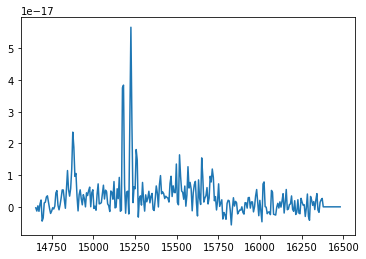

In [4]:
plt.plot(axis, sky)

In [31]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('../Reference-Spectrum-R1800.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = np.array(channel[min_:max_])
print(wavenumbers_syn)

[14701.784  14707.211  14712.638  14718.065  14723.492  14728.919
 14734.346  14739.773  14745.2    14750.627  14756.055  14761.481
 14766.908  14772.335  14777.763  14783.189  14788.616  14794.043
 14799.471  14804.897  14810.324  14815.751  14821.179  14826.605
 14832.032  14837.459  14842.887  14848.313  14853.74   14859.168
 14864.595  14870.021  14875.448  14880.876  14886.303  14891.7295
 14897.156  14902.584  14908.011  14913.4375 14918.864  14924.292
 14929.719  14935.1455 14940.572  14946.     14951.427  14956.854
 14962.281  14967.708  14973.135  14978.562  14983.989  14989.416
 14994.843  15000.27   15005.697  15011.124  15016.551  15021.978
 15027.405  15032.832  15038.259  15043.686  15049.113  15054.54
 15059.967  15065.395  15070.821  15076.248  15081.675  15087.103
 15092.529  15097.956  15103.383  15108.811  15114.237  15119.664
 15125.091  15130.519  15135.945  15141.372  15146.799  15152.227
 15157.653  15163.08   15168.508  15173.935  15179.361  15184.788
 15190.216

In [6]:
f = interpolate.interp1d(axis, sky, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale 
print(sky_corr.shape)

(166,)


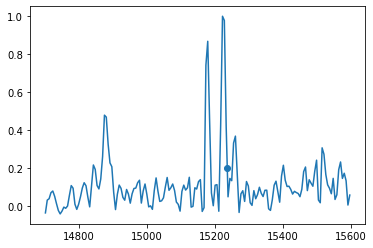

In [7]:
plt.plot(np.array(wavenumbers_syn), sky_corr)
plt.scatter([15237], [0.2])

In [33]:
model = keras.models.load_model('../R1800-PREDICTOR-I')

Spectrum = sky_corr.reshape(1, sky_corr.shape[0], 1)
predictions = model(Spectrum, training=False)
vel_ml = float(predictions[0][0])
broad_ml = float(predictions[0][1])
print(vel_ml, broad_ml)
line_halpha = 656.28
line_ml = 1e7/((vel_ml/3e5)*line_halpha + line_halpha)
print(line_ml)
# Calculate flux estimate
line_ind = np.argmin(np.abs(np.array(wavenumbers_syn)-line_ml))
print([sky_corr[line_ind-2],sky_corr[line_ind-1], sky_corr[line_ind], sky_corr[line_ind+1], sky_corr[line_ind+2]])
flux_est = np.max([sky_corr[line_ind-2],sky_corr[line_ind-1], sky_corr[line_ind], sky_corr[line_ind+1], sky_corr[line_ind+2]])

print(flux_est)

99.49649047851562 138.42535400390625
15232.346787808374
[1.0, 0.9776594043922716, 0.415106937442219, 0.046699574244032045, 0.14376544916948136]
1.0


In [ ]:
halpha_cm1 = 1e7/line_halpha
print(halpha_cm1)
max_flux = np.argmax(sky)
print(axis[max_flux])
vel_ml = np.abs(3e5*((axis[max_flux]-halpha_cm1)/halpha_cm1))
print(vel_ml)

In [9]:
A_min = 0#1e-19
A_max = 1.#1e-15
x_min = 14700
x_max = 15400
sigma_min = 0
sigma_max = 100

class Gaussian:
    def __init__(self, channel, params):
        A = params[0]; x = params[1]; sigma = params[2]
        self.func = A*np.exp((-(channel-x)**2)/(2*sigma**2))
        
    def jac_func(self, channel, params):
        A = params[0]; x = params[1]; sigma = params[2]
        dA = np.exp((-(channel-x)**2)/(2*sigma**2))
        dx = A*np.exp((-(channel-x)**2)/(2*sigma**2))*(channel-x)/sigma**2
        dsigma = A*np.exp((-(channel-x)**2)/(2*sigma**2))*(channel-x)**2/sigma**3
        return np.array([dA, dx, dsigma])

    
# Update the model
def gaussian_model(channel, theta, models):
    """
    """
    f1 = 0.0
    for model_num in range(len(models)):
        params = theta[model_num*3:(model_num+1)*3]
        f1 += Gaussian(channel, params).func
    return f1

# Update the model
def gaussian_model_der(channel, theta, models):
    """
    """
    f1 = np.zeros(3)
    for model_num in range(len(models)):
        params = theta[model_num*3:(model_num+1)*3]
        gaussian = Gaussian(channel, params)
        f1 = gaussian.jac_func(channel, params)
    return f1

In [10]:
def log_likelihood(theta, x, y, yerr, model):
    """
    theta - list of parameters for gaussian fit
    """
    #if model == 1:
    #    A_,B_,x_,sigma_ = theta
    #    model = gaussian_model(x, A_, B_, x_, sigma_)
    #elif model == 2:
    #    A_,B_,x_,sigma_, A2_, x2_, sigma2_ = theta
    #    model = gaussian_model2(x, A_, B_, x_, sigma_, A2_, x2_, sigma2_)
    model = gaussian_model(x, theta, model)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))



In [21]:
line_dict = {'Halpha': 656.280, 'NII6583': 658.341, 'NII6548': 654.803, 'SII6716': 671.647, 'SII6731': 673.085}
def line_vals_estimate(spec, line_name):
    line_theo = line_dict[line_name]
    line_pos_est = 1e7/((vel_ml/3e5)*line_theo + line_theo)  # Estimate of position of line in cm-1
    print(line_pos_est)
    line_ind = np.argmin(np.abs(np.array(axis)-line_pos_est))
    line_amp_est = np.max([sky_corr[line_ind-2],sky_corr[line_ind-1], sky_corr[line_ind], sky_corr[line_ind+1], sky_corr[line_ind+2]])
    line_broad_est = (line_pos_est*broad_ml)/3e5
    return line_amp_est, line_pos_est, line_broad_est
    
model = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
nll = lambda *args: -log_likelihood(*args)
initial = np.ones((3*len(model)))
sky_scale = np.max(sky)
sky_norm = sky/sky_scale
bounds_ = []#np.zeros((3*len(model), 2))
#print(bounds)
#bounds = Bounds([0, -0.5], [1.0, 2.0])
for mod in range(len(model)):
    val = 3*mod + 1
    amp_est, vel_est, sigma_est = line_vals_estimate(sky_norm, model[mod])
    initial[3*mod] = amp_est
    initial[3*mod + 1] = vel_est
    initial[3*mod + 2] = sigma_est
    bounds_.append((A_min, A_max))
    bounds_.append((x_min, x_max))
    bounds_.append((sigma_min, sigma_max))
bounds_l = [val[0] for val in bounds_]
bounds_u = [val[1] for val in bounds_]
bounds = Bounds(bounds_l, bounds_u)
print(initial)
cons = ({'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[1]-line_dict['Halpha'])/(1e7/x[1]))},
        {'type': 'eq', 'fun': lambda x: x[2] - x[5]},
        {'type': 'eq', 'fun': lambda x: x[5] - x[8]},
        {'type': 'eq', 'fun': lambda x: x[5] - x[11]},
        {'type': 'eq', 'fun': lambda x: x[5] - x[14]},
        {'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[7]-line_dict['NII6548'])/(1e7/x[7]))},
        {'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[10]-line_dict['SII6716'])/(1e7/x[10]))},
        {'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[13]-line_dict['SII6731'])/(1e7/x[13]))})

        
def fun_der(theta, axis, y, yerr, model):
    return Jacobian(lambda theta: log_likelihood(theta, axis, y, yerr, model))(theta).ravel()

soln = minimize(nll, initial, method='SLSQP',# jac=fun_der,
                options={'disp': True}, bounds=bounds, tol=1e-2,
                args=(axis, sky_norm, 1e-2, model), constraints=cons)
init_var = soln.x
line_fit = 1e7/((init_var[1]/3e5)*line_halpha + line_halpha)
print(init_var)
print(3e5*((1e7/init_var[1] - 656.28)/(1e7/init_var[1])))
#print(3e5*((1e7/init_var[4] - line_dict['NII6583'])/(1e7/init_var[4])))
print(3e5*init_var[2]/init_var[1])
#print(3e5*((1e7/init_var[1]-656.28)/(1e7/init_var[1])))
#for i in range(len(model)):
#    init_var[i] = init_var[i]/sky_scale

15232.346787808374
15184.660456971205
15266.705482263947
14883.837119651958
14852.038821104139
[4.54147729e-01 1.52323468e+04 7.02847665e+00 1.37358044e-01
 1.51846605e+04 7.00647333e+00 1.00000000e+00 1.52667055e+04
 7.04433037e+00 3.24718907e-01 1.48838371e+04 6.86766807e+00
 4.77784465e-01 1.48520388e+04 6.85299577e+00]


/home/carterrhea/anaconda3/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6308.120079168070985
            Iterations: 19
            Function evaluations: 324
            Gradient evaluations: 19
[1.00000000e+00 1.52256619e+04 4.95977357e+00 8.03760624e-01
 1.51779965e+04 4.95977357e+00 3.50719004e-01 1.52600055e+04
 4.95977357e+00 4.82805387e-01 1.48773051e+04 4.95977357e+00
 2.08952489e-01 1.48455208e+04 4.95977357e+00]
231.07908536776606
97.7252802602939


[4.40025224e-17 1.52256619e+04 4.95977357e+00 3.53674949e-17
 1.51779965e+04 4.95977357e+00 1.54325208e-17 1.52600055e+04
 4.95977357e+00 2.12446549e-17 1.48773051e+04 4.95977357e+00
 9.19443658e-18 1.48455208e+04 4.95977357e+00]


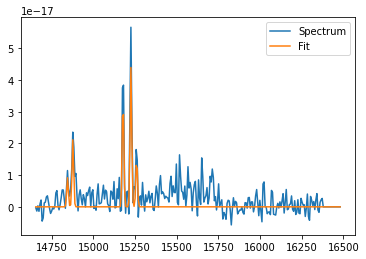

Calculated velocity: 231.08 km/s
Calculated broadening: 97.73 km/s


In [22]:
#if model == 1:
parameters = soln.x
for i in range(len(model)):
    parameters[i*3] *= sky_corr_scale
print(parameters)
#if model == 2:
    #parameters = [mean_[0], mean_[1],  mean_[2], mean_[3], mean_[4], mean_[5]]
final_model = gaussian_model(axis, parameters, model)
plt.clf()
plt.plot(axis, sky, label='Spectrum')
plt.plot(axis, final_model, label='Fit')
plt.legend()
#plt.xlim(650, 675)
plt.show()
l_calc = 1e7/parameters[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)
print("Calculated broadening: %.2f km/s"%(3e5*parameters[2]/parameters[1]))

In [23]:
def log_prior(theta, model):
    for model_num in range(len(model)):
        params = theta[model_num*3:(model_num+1)*3]
    within_bounds = True  # Boolean to determine if parameters are within bounds
    for ct, param in enumerate(params):
        if ct%3 == 0:  # Amplitude parameter
            if param > A_min and param < A_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 1:  # velocity parameter
            if param > x_min and param < x_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 2:  # sigma parameter
            if param > sigma_min and param < sigma_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
    if within_bounds:
        return 0.0
    else:
        return -np.inf
    #A_,x_,sigma_ = theta
    #if A_min < A_ < A_max and x_min < x_ < x_max and sigma_min < sigma_ < sigma_max:
    #    return 0.0#np.log(1/((t_max-t_min)*(rp_max-rp_min)*(b_max-b_min)))
    #return -np.inf



In [24]:
def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)

In [25]:
n_dim = 3 * len(model)
n_walkers = n_dim * 2 + 4

init_ = init_var + 1 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(axis, sky_norm, 1e-2, model))
sampler.run_mcmc(init_, 500, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/home/carterrhea/anaconda3/envs/orb3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:05<00:00, 84.38it/s] 


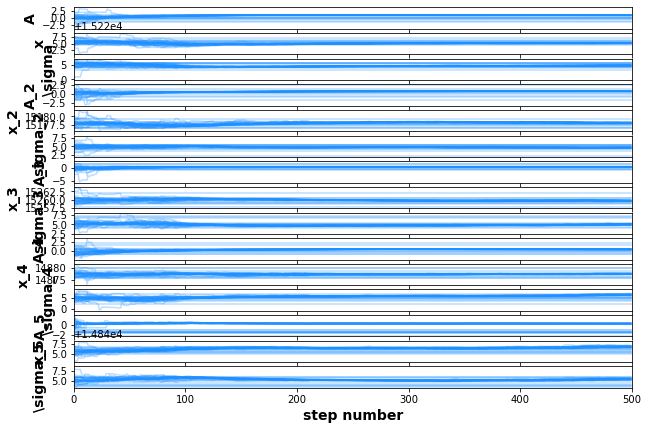

In [26]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
if len(model) == 1:
    labels = [r"A", r"x", "sigma"]
elif len(model) == 2:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2"]
elif len(model) == 3:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3"]
elif len(model) == 4:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3", r"A_4", r"x_4", r"\sigma_4"]
elif len(model) == 5:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3", r"A_4", r"x_4", r"\sigma_4", r"A_5", r"x_5", r"\sigma_5"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", color='dodgerblue', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontweight='bold', fontsize=14)
    #ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number", fontsize=14, fontweight='bold');
plt.savefig('Emcee-steps.png')

In [27]:
flat_samples = sampler.get_chain(discard=200, flat=True)
parameters = []
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[1.007725986823956, 15225.146234260897, 4.681541916296797, 0.7837833448674327, 15178.252587362449, 4.732220304897583, 0.34746072610217626, 15259.763000835788, 4.79587728046078, 0.46136141588499063, 14877.284783720292, 6.00791487691608, 0.21553393403061724, 14846.412179761333, 5.166508451379652]


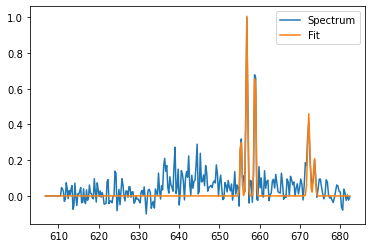

In [28]:
#if model == 1:
print(parameters)
#if model == 2:
    #parameters = [mean_[0], mean_[1],  mean_[2], mean_[3], mean_[4], mean_[5]]
final_model = gaussian_model(axis, parameters, model)
plt.clf()
plt.plot(1e7/axis, sky_norm, label='Spectrum')
plt.plot(1e7/axis, final_model, label='Fit')
#plt.xlim(650, 675)
plt.legend()

In [29]:
l_calc = 1e7/parameters[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)

Calculated velocity: 241.23 km/s


In [30]:
print("Calculated velocity dispersion: %.2f km/s"%(parameters[2]*3e5/(parameters[1])))

Calculated velocity dispersion: 92.25 km/s
